In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [2]:
pdb='2F4K.protein.pdb'
trajectory='2F4K.protein.s10.dcd'
xray_CA_pdb='2f4K.xray.CA.pdb'

In [3]:
stride_sel=2
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 31396

Starting frame: 0

Last frame: 31396

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'A

In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [6]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [7]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


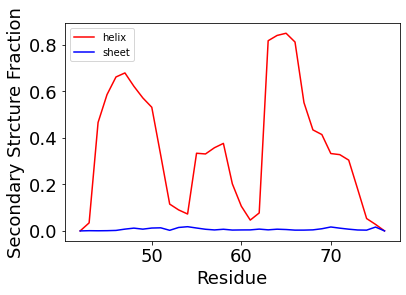

In [8]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [9]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

/usr/local/anaconda3/envs/omm/lib/python3.6/site-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]


In [10]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [11]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




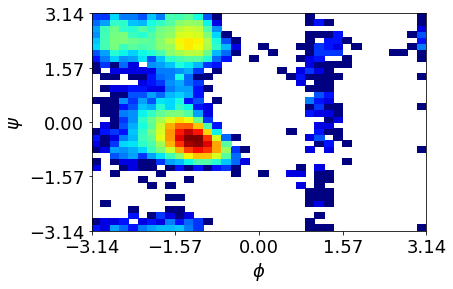

In [12]:
plot_phipsi(45)


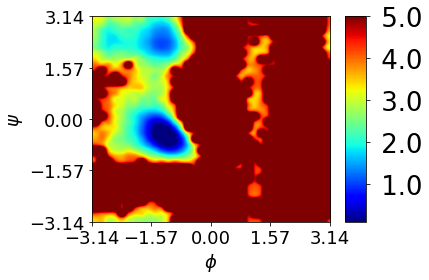

In [13]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],normed=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(45)

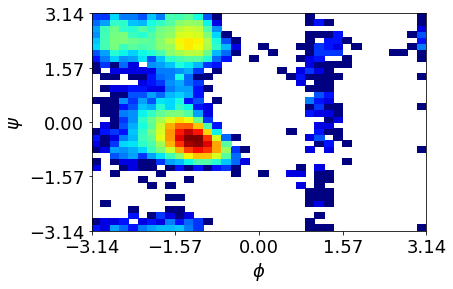

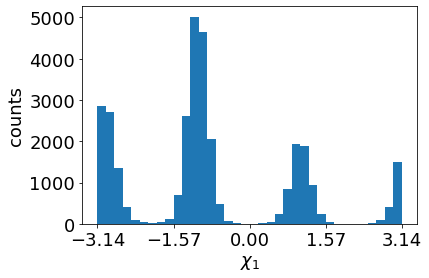

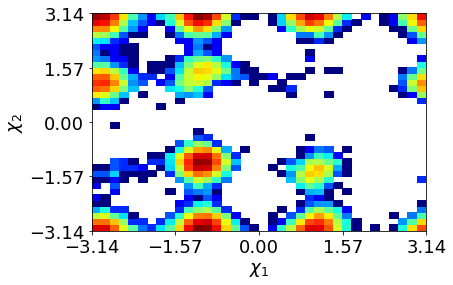

In [14]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [15]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [16]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 31396 frames, 35 atoms, 35 residues, and unitcells at 0x7f8d65e03780>

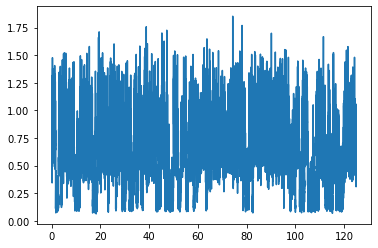

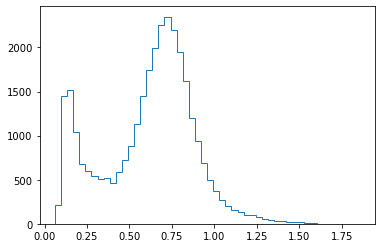

In [17]:
#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

In [18]:
native_frames=np.where(rmsd<0.25)[0]
len(native_frames)
trj[native_frames].save_dcd('native.dcd')

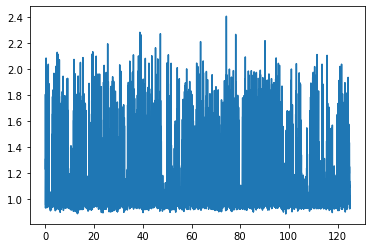

In [19]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [20]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(31396, 2)


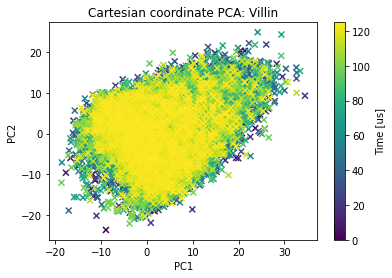

In [21]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

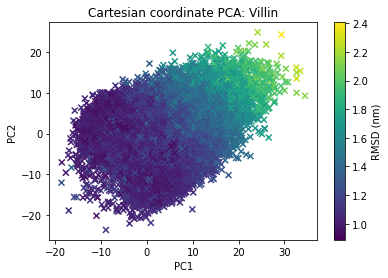

In [22]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

In [23]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

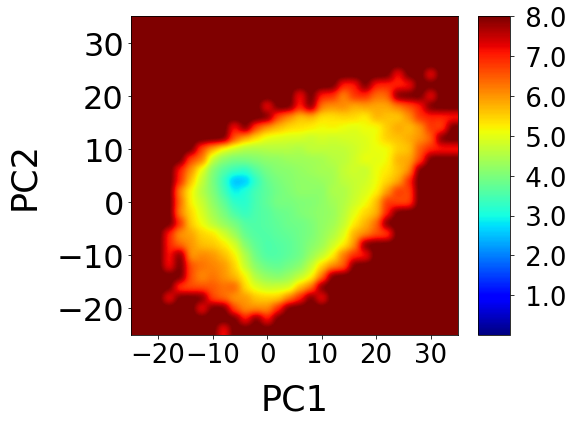

In [24]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

/usr/local/anaconda3/envs/omm/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  """


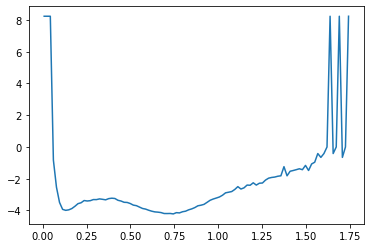

In [25]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a, T,x0, xmax, bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], normed=False, weights=None)
    xcenters = xedges[:-1]+ np.diff(xedges)/2
    free_energy = np.log(free_energy+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters

dG_RMSD,xedges = free_energy1D(rmsd, 300, 0, 1.75, 100)
plt.plot(xedges, dG_RMSD)

/usr/local/anaconda3/envs/omm/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  """


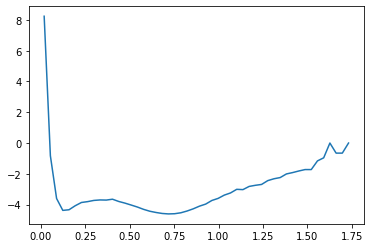

In [26]:
dG_RMSD,xedges = free_energy1D(rmsd, 300, 0, 1.75, 50)
plt.plot(xedges, dG_RMSD)

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

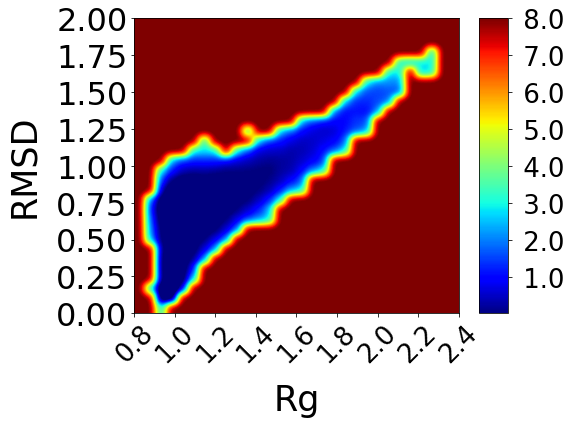

In [27]:
dG,xedges,yedges=free_energy(rmsd, rg, 300, 0, 2, 0.8, 2.4)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26',rotation=45)
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

In [28]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [29]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

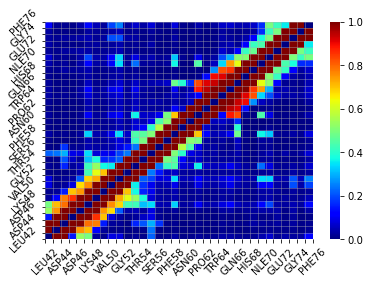

In [30]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [31]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [32]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [33]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

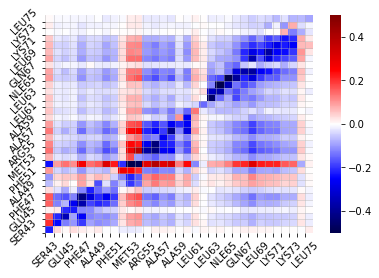

In [34]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

In [35]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351



In [36]:
#summing over a certain set of native contacts


First we need to determine the native contacts and calculate Q



In [37]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x7f8d65ccb630>

In [38]:
#Lets Make a 1D array that contains all native distances pairs:
native_distance_matrix1D=[]
#QUESTION: How can you make a 1D Array that only contains distances between residue pairs seperated by more than 7 residues
for i in range(0, 35):
    for j in range(0,35):
        if(abs(i-j)>7):
            dist=md.compute_distances(xray_CA, [[i,j]])[0]
            native_distance_matrix1D.append(dist[0])

native_distance_matrix1D
#Convert to Angstrom (*10)
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10
print(native_distance_matrix1D)

[ 9.288557  11.002597  13.174997  12.974674  11.456033   9.985726
 11.460043  14.596794  13.557264  11.562319  13.011403  16.130928
 17.153845  16.867903  20.679474  19.010408  15.606644  16.592367
 18.033709  14.887061  12.800236  15.757791  16.287163  12.9909115
 13.24484   10.320788  10.4021435 11.979639  13.129105  12.526512
 10.452459   9.704253  11.858181  14.817125  14.141106  13.34659
 14.36302   17.875956  19.44044   19.661098  23.102034  20.870422
 17.597794  19.201468  20.525543  17.176662  15.681386  18.858025
 18.98656   15.687101  16.518223  13.808665  13.982572  10.919163
  9.60349    7.0967283  7.0852814  9.99271   11.701868  11.763029
 13.330956  14.182544  17.105116  19.51937   19.905045  21.878319
 19.377485  16.37223   18.638575  19.799309  16.400278  15.666395
 19.12473   18.929142  15.985601  17.549322  15.002321  15.272311
  9.574567   8.303897   9.653462   9.792494  12.350922  13.557655
 12.426256  12.379509  16.166704  18.420822  19.58403   23.047237
 20.577105

In [39]:
np.shape(native_distance_matrix1D)

(756,)

In [40]:
#Now lets do the same thing for our trajectory, making an array that is contacts vs. #frames in the trajectory

traj_CA_distance_matrix1D=[]
for i in range(0, 35):
    for j in range(0,35):
        if(abs(i-j)>7):
            dist=md.compute_distances(trjCA, [[i,j]])[:,0]
            traj_CA_distance_matrix1D.append(dist)
        
#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10

np.shape(traj_CA_distance_matrix1D)

(756, 31396)

In [41]:
print(traj_CA_distance_matrix1D)

[[16.155031  15.260145  17.395828  ... 12.595214  10.365486  12.631355 ]
 [14.991053  16.925203  13.891735  ... 14.420662  12.177633  13.6923685]
 [12.063679  15.076105  13.541395  ... 15.570398  14.053832  15.135903 ]
 ...
 [19.731848  23.362614  11.990379  ... 15.411287  13.415974  14.883488 ]
 [17.971453  23.224693   9.6383915 ... 14.890996  14.566812  14.951433 ]
 [15.186663  20.220787  12.7929325 ... 11.400409  11.721592  11.634714 ]]


In [42]:
np.shape(traj_CA_distance_matrix1D[:,native_frames])
#Distances For All CA-CA pairs in the native frames
traj_CA_distance_matrix1D[:,native_frames]
native_average=np.average(traj_CA_distance_matrix1D[:,native_frames],axis=1)
np.shape(native_average)

(756,)

In [43]:
Native_Contact_Indices=np.where(native_average<10.0)[0]
len(Native_Contact_Indices)

46

In [44]:
Native_Contacts_Trj_Dist=traj_CA_distance_matrix1D[Native_Contact_Indices]
np.shape(Native_Contacts_Trj_Dist)

Native_Contacts_Xray_Dist=native_distance_matrix1D[Native_Contact_Indices]

In [45]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Xray_Distance_Expand=np.zeros(np.shape(Native_Contacts_Trj_Dist))
for i in range(0,len(Native_Contacts_Trj_Dist)):
    Xray_Distance_Expand[i,:]=Native_Contacts_Xray_Dist[i]
    
Xray_Distance_Expand


array([[ 9.98572636,  9.98572636,  9.98572636, ...,  9.98572636,
         9.98572636,  9.98572636],
       [10.45245934, 10.45245934, 10.45245934, ..., 10.45245934,
        10.45245934, 10.45245934],
       [ 9.7042532 ,  9.7042532 ,  9.7042532 , ...,  9.7042532 ,
         9.7042532 ,  9.7042532 ],
       ...,
       [ 7.79883337,  7.79883337,  7.79883337, ...,  7.79883337,
         7.79883337,  7.79883337],
       [ 9.57147789,  9.57147789,  9.57147789, ...,  9.57147789,
         9.57147789,  9.57147789],
       [ 9.27620125,  9.27620125,  9.27620125, ...,  9.27620125,
         9.27620125,  9.27620125]])

In [46]:
for i in range(0,len(Native_Contacts_Trj_Dist)):
    print(Native_Contacts_Xray_Dist[i],Native_Contacts_Trj_Dist[i])

9.985726 [11.540491 11.015314 11.790983 ... 10.036934  9.802754  9.529006]
10.452459 [ 9.374432  11.174518  13.940148  ...  8.681303   8.4822445  8.788097 ]
9.704253 [11.477718  11.518175  11.575023  ...  8.135482   7.9602337  7.693935 ]
9.60349 [ 9.620813   9.833138  11.725578  ...  8.641678   7.9195204  7.720747 ]
7.0967283 [ 8.358078   8.165926  10.151951  ...  5.1410217  4.8814363  5.1262226]
7.0852814 [10.051856   8.767696   7.785823  ...  5.7071185  5.715454   5.3546863]
9.99271 [13.804028  12.2466545  7.203826  ...  8.439341   8.040899   8.60963  ]
9.574567 [12.595353  6.733689 10.749725 ...  9.001774  9.501221  9.204168]
8.303897 [11.918608   6.0125976 10.248171  ...  6.756706   7.458983   7.861574 ]
9.653462 [13.711605  6.118204  8.700054 ...  8.701403  9.374109  8.898192]
9.633482 [12.349012  7.886838 11.7558   ...  7.593482  8.530871  8.578752]
10.225195 [14.985344  9.100551 11.108248 ...  8.763982 10.023594  8.658443]
6.8318415 [12.484558   9.575733   9.27474   ...  6.30730

In [47]:
np.shape(Native_Contacts_Xray_Dist)

(46,)

In [48]:
#Write a function to Calculate Q 
def qCalc(dist,nativedist):
    num=np.sum(1/(1+np.exp(10*np.subtract(dist,nativedist+1))))
    denom=46
    q_in=num/denom
    return q_in

In [49]:
q_map = []
for i in range(0, 31396):
    qinit=qCalc(Native_Contacts_Trj_Dist[:,i],Native_Contacts_Xray_Dist)
    q_map.append(qinit)
np.shape(q_map)

/usr/local/anaconda3/envs/omm/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


(31396,)

In [51]:
#Plot Q and a Histogram

plt.plot(time,q_map,linewidth=0.1)
plt.xlabel("Time ($\mu$s)",size=18)
plt.ylabel("Q",size=18)
plt.show()
plt.hist(q_map,bins=10,range=[0,1],histtype='step')
plt.show()

In [52]:
#Plot Q using only our native frames


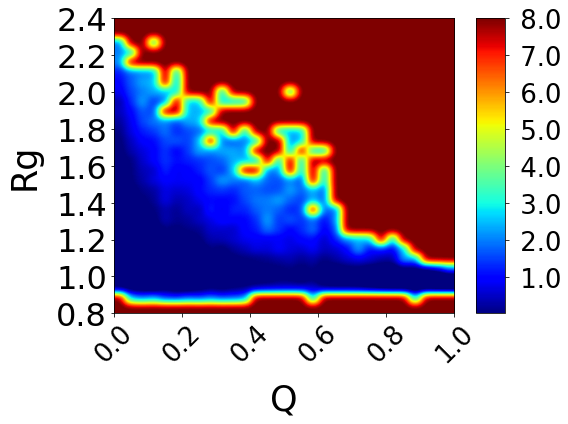

In [53]:
#2.) Plot some 2D free energy surfaces (Q vs. Rg) (Advanced: Plot Q vs. Fraction Helix)
dG,xedges,yedges=free_energy(rg, q_map, 300, 0.8, 2.4, 0, 1)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26',rotation=45)
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

In [54]:
dG,xedges,yedges=free_energy(rmsd, q_map, 300, 0, 2, 0, 1)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 0.5, 1, 1.5, 2]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26',rotation=45)
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=2)
plt.yticks(size='26')
plt.tight_layout()

In [55]:
#Unsure about the voids shown in the plot above?
#Fixed with a lower stride of 2

In [56]:
#Consider using a windowing function to smooth our values of Q for Transition Path Calculations


In [57]:
#3.) Use the dual cut-off approach with Q to identify transition paths.  This means from the distribution of Q 
#you decide on a threshold for folded and unfolded states, you assign a transition between to states as every event 
#where you start beneath one threshold and your cross over the second threshold.

In [58]:
np.shape(q_map)

(31396,)

In [159]:
total_forward = []
for i in range(0,len(q_map)):
    if q_map[i]<0.15:
        tro = 1
    if q_map[i]>0.85:
        tro = 0
    total_forward.append(tro)
    
total_reverse = []
reverse = []
for i in range(1,len(q_map)+1):
    if q_map[len(q_map)-i]<0.15:
        tro = 1
    if q_map[len(q_map)-i]>0.85:
        tro = 0
    reverse.append(tro)
total_reverse = np.flip(reverse)

In [160]:
total_reverse

array([1, 1, 1, ..., 1, 1, 1])

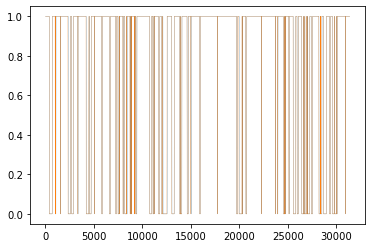

In [161]:
plt.plot(total_forward,linewidth=0.25)
plt.plot(total_reverse,linewidth=0.25)


In [239]:
trans = []
for i in range(0,len(q_map)):
    if total_forward[i]!=total_reverse[i]:
        trans.append(i)
        
folded = []
for i in range(0,len(q_map)):
    if total_forward[i]==1:
        if total_forward[i]==total_reverse[i]:
            folded.append(i)    

unfolded = []
for i in range(0,len(q_map)):
    if total_forward[i]==0:
        if total_forward[i]==total_reverse[i]:
            unfolded.append(i)    
            

In [246]:
print(len(unfolded)+len(folded)+len(trans))
print(len(q_map))

31396
31396


In [193]:
print(trans)

[390, 391, 392, 692, 693, 694, 695, 696, 697, 698, 699, 700, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1016, 1017, 1018, 1019, 1020, 1021, 1023, 1024, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2580, 2581, 2582, 2583, 2584, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2886, 2887, 2888, 2889, 2890, 3355, 3356, 3357, 3358, 3359, 4188, 4189, 4190, 4191, 4192, 4193, 419

In [196]:
trans=(time[10750], time[10751], time[10942], time[10943], time[10944], time[10945], time[10946], time[10947], 
       time[10948], time[10949], time[10950], time[10951], time[10952], time[11086], time[11087], time[11088], 
       time[11089], time[11163], time[11164], time[11165], time[11166], time[11167], time[11168], time[11169], 
       time[11170], time[11171], time[11172], time[11173], time[11174], time[11175], time[11176])

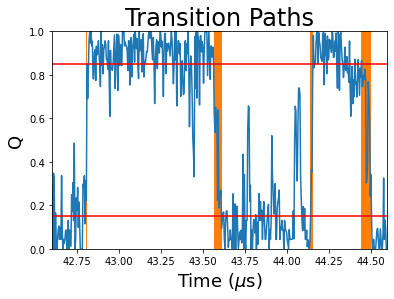

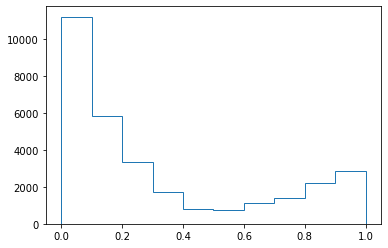

In [231]:
plt.plot(time[10700:11200],q_map[10700:11200])
plt.hist(trans,bins=300)
plt.plot([time[10700],time[11200]],[0.85,0.85],"r")
plt.plot([time[10700],time[11200]],[0.15,0.15],"r")
plt.xlabel("Time ($\mu$s)",size=18)
plt.ylabel("Q",size=18)
plt.xlim([time[10700],time[11200]])
plt.ylim([0,1])
plt.title("Transition Paths",size=24)
plt.show()
plt.hist(q_map,bins=10,range=[0,1],histtype='step')
plt.show()

In [66]:
#5) Calculate Contact Maps, Dihedral Correlations, and secondary structure propensities for A) The unfolded States 
#B) Transition Paths C) The folded states



In [251]:
contact_maps = []
for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
final_map_folded = np.asarray(contact_maps).astype(float)



KeyboardInterrupt: 

In [ ]:
#6)  Ask and answer a question about the transition paths, either globally 
#(about the statistical properties of all transition paths - ie. what is the probability of forming a certain 
#set of native contacts in the first 50% of transition paths, what is the average helical propensity in the 
#first and second halves of transition paths)), or locally (what is the sequence of native contact 
#formation and helix formation in some particular transition paths)